 ResNet50 es un modelo de CNN que supuso una revolución en el campo del Deep Learning en el momento de su salida. Utilizando este modelo de base, realizaremos Transfer Learning para utilizar una red de este tipo previamente entrenada en ImageNet para el diagnóstico de neumonías pulmonares en imagenes de rayos X. También probaremos con otros modelos diferentes para discernir cuál proporciona mejores resultados en este problema.

El dataset puede obtenerse en: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

#Ruta de acceso al dataset

Modificar este parámetro en caso de que el dataset no se suba en la carpeta principal de Drive

In [ ]:
path_dataset = "/content/gdrive/MyDrive/chest_xray/"

#Librerias y Funciones Previas

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Importar librerías necesarias
import numpy as np
import uuid
import tensorflow as tf
from matplotlib import pyplot as plt

#Vamos a usar el recolector de basura para ahorrar recursos en Colab
import gc
import keras 

# Lectura y preprocesamiento de datos
from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator,img_to_array,image_dataset_from_directory
from keras.utils import np_utils
from keras import backend as K

# Importar modelos y capas específicas que se van a usar
from keras.models import Sequential,Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.resnet import preprocess_input

Mounted at /content/gdrive


In [ ]:
#Función para mostrar imágenes del dataset
def visualizar_dataset(dataset):
  batch_visualizar=dataset.take(16)
  plt.figure(uuid.uuid4(),figsize=(10,10))
  i=0
  for images, labels in batch_visualizar:
      ax = plt.subplot(4, 4, i + 1)
      if(labels.numpy()[i]==0):
        ax.set_title("Normal")
      else:
        ax.set_title("Pneumonia")
      i=i+1
      plt.imshow(images[i].numpy().astype("uint8"))
    
  plt.subplots_adjust(hspace=0.4, wspace=0.3)

#Función para ver la evolución del entrenamiento en las diferentes épocas
def mostrarEvolucion(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training loss', 'Validation loss'])
    plt.show()
    
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training accuracy','Validation accuracy'])
    plt.show()

In [ ]:
#Funciones para realizar el preprocesado de los diferentes modelos utilizados
def preprocess_resnet(images, labels):
  return tf.keras.applications.resnet50.preprocess_input(images), labels

def preprocess_vgg(images, labels):
  return tf.keras.applications.vgg16.preprocess_input(images), labels

def preprocess_mobile(images,labels):
  return tf.keras.applications.mobilenet_v2.preprocess_input(images),labels

#Función para realizar stopping en el entrenamiento
class haltCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss') <= 0.1 and logs.get('val_accuracy') >= 0.96):
            print("\---------------Perdida y Precisión deseadas alcanzadas!---------------")
            self.model.stop_training = True

trainingStopCallback = haltCallback()


Implementación de ResNet18 - Código modificado de :
https://www.kaggle.com/songrise/implementing-resnet-18-using-keras/notebook

In [ ]:
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf


class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="sigmoid") ###Retocado solo vale para clasificacion binaria

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

#Importar el dataset y preprocesamiento. Calculo de pesos

In [ ]:
#Datos de entrenamiento utilizando una porción del conjunto de training como conjunto de validación
train_set = image_dataset_from_directory(path_dataset+"train",image_size=(224,224),batch_size=128,seed=123,label_mode='int',shuffle=True,validation_split=0.2,subset='training')
validation_set = image_dataset_from_directory(path_dataset+"train",image_size=(224,224),batch_size=128,seed=123,label_mode='int',shuffle=True,validation_split=0.2,subset='validation')
test_set = image_dataset_from_directory(path_dataset+"test",image_size=(224,224),label_mode='int',shuffle=True)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Found 624 files belonging to 2 classes.


En este fragmento leemos las imágenes del dataset. Si se examinan éstas, se puede ver como no son todas del mismo tamaño, y en general tienen tamaños muy grandes. Para reducir el tiempo de entrenamiento, leemos todas las imágenes como imágenes de 224x224 (keras realiza por nosotros las interpolaciones necesarias para obtener dicho tamaño, por defecto de tipo bilinear).

El dataset contiene muy pocas imágenes para realizar la validación (solamente 16). En lugar de utilizar las imágenes proporcionadas, reservamos una parte del training para realizar la validación.

Para que se pueda realizar correctamente, debemos fijar el parámetro *seed*, con el fin de que no se incluya ninguna imagen simultáneamente en el conjunto de training y en el de validation.

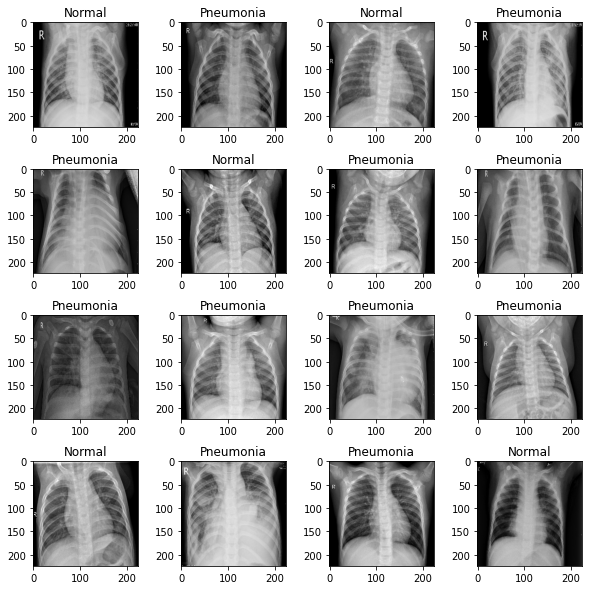

In [ ]:
#Train_set sin preprocesado
visualizar_dataset(train_set)

Al utilizar redes ya entrenadas, es necesario preprocesar las imágenes de entrada para que se adapten a las admitidas por éstas. Estos cambios pueden ser diversos (tamaño, colores,etc). Para ello, Keras nos proporciona diversas funciones que realicen este preprocesado, teniendo cada modelo la suya específica. Inicialmente, vamos a aplicar la asociada a ResNet50, que va a ser el primer modelo que vamos a utilizar.

In [ ]:
train_set = train_set.map(preprocess_resnet)
validation_set = train_set.map(preprocess_resnet)
test_set = train_set.map(preprocess_resnet)

 A continuación se muestran algunas imágenes del conjunto de training una vez preprocesadas para ser utilizadas en ResNet50, para que se puedan comparar con las imágenes originales vistas antes:

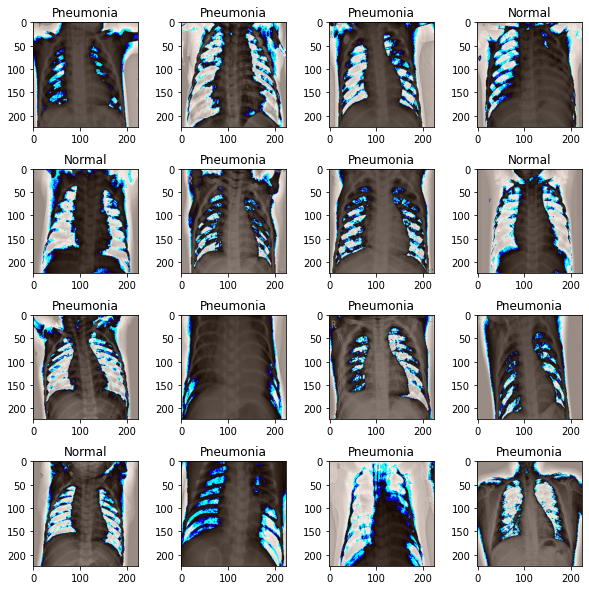

In [ ]:
visualizar_dataset(train_set)

Si se realiza una pequeña exploración del conjunto de entrenamiento, se puede ver como las dos clases que lo componen están desbalanceadas: existen aproximadamente 1500 imágenes sin neumonía frente a 4500 con neumonía.

Para solucionar este problema, asignamos un mayor peso al inicio del entrenamiento a las imágenes sin neumonía. El código siguiente realiza el cálculo de los pesos (almacenados en la variable **class_weight**), el cual se utilizará en todos los entrenamientos del proyecto.

In [ ]:
import os
normal_dir = path_dataset+"train/NORMAL"
pneumonia_dir = path_dataset+"train/PNEUMONIA"

num_normal =  len(os.listdir(normal_dir))
num_pneumonia =  len(os.listdir(pneumonia_dir))

print("Normal: ",num_normal)
print("Pneumonia: ",num_pneumonia)

# Class weights

weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Normal:  1342
Pneumonia:  3876
Weight for class 0: 0.74
Weight for class 1: 0.26


#ResNet50

Descargamos el modelo pre-entrenado con ImageNet de la API de keras:

In [ ]:
resnet = tf.keras.applications.ResNet50(include_top=False,
                                      weights='imagenet',
                                      pooling='avg',
                                      input_shape = (224,224,3))
resnet.trainable=False

Al ser un problema de clasificación binaria, añadimos a la salida de ResNet50 una única FC layer con un único nodo. La función de activación en este caso será la sigmoide, como dictan las convenciones de nuestro problema:

In [ ]:
model = Sequential()
model.add(resnet)
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


Compilamos nuestro modelo, utilizando :

*   **Optimizador**: Adam, debido a su facilidad para salir de puntos de silla y su rapidez en moverse por los gradientes
*   **Función de perdida**: BinaryCrossentropy, por ser un problema de clasificación binaria
*   **Métrica**: Accuracy

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy'])

Entrenamos, indicando que utilice los pesos iniciales detallados anteriormente.

Epoch 1/20
33/33 [==============================] - 80s 2s/step - loss: 0.1304 - accuracy: 0.8454 - val_loss: 0.1819 - val_accuracy: 0.9363
Epoch 2/20
33/33 [==============================] - 71s 2s/step - loss: 0.0617 - accuracy: 0.9353 - val_loss: 0.1510 - val_accuracy: 0.9427
Epoch 3/20
33/33 [==============================] - 71s 2s/step - loss: 0.0501 - accuracy: 0.9475 - val_loss: 0.1376 - val_accuracy: 0.9492
Epoch 4/20
33/33 [==============================] - 71s 2s/step - loss: 0.0439 - accuracy: 0.9549 - val_loss: 0.1283 - val_accuracy: 0.9533
Epoch 5/20
33/33 [==============================] - 70s 2s/step - loss: 0.0394 - accuracy: 0.9600 - val_loss: 0.1223 - val_accuracy: 0.9540
Epoch 6/20
33/33 [==============================] - 71s 2s/step - loss: 0.0358 - accuracy: 0.9641 - val_loss: 0.1158 - val_accuracy: 0.9557
Epoch 7/20
33/33 [==============================] - 71s 2s/step - loss: 0.0337 - accuracy: 0.9662 - val_loss: 0.1126 - val_accuracy: 0.9573
Epoch 8/20
33/33 [==

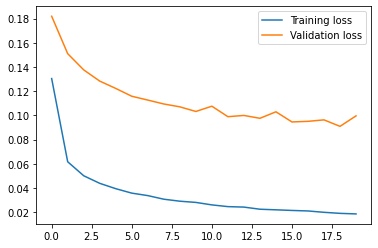

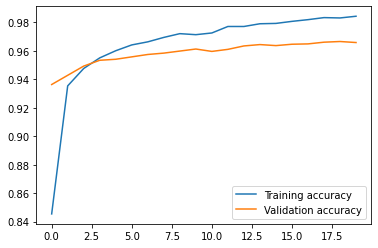

In [ ]:
hist = model.fit(x=train_set,
                 validation_data=validation_set,
                 class_weight=class_weight,
                 epochs=20)
mostrarEvolucion(hist)

In [ ]:
# APLICAMOS EL TEST
score = model.evaluate(test_set, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.09959477931261063
Test accuracy: 0.9657320976257324


Como vemos ha sido muy sencillo obtener una precisión alta, gracias a que el problema de imagenet tiene muchas clases, por lo que los niveles más bajos del modelo han aprendido a generalizar y a obtener las caracteristicas importantes de las imagenes que pueden ser utiles para clasificarlas. Si bien el rendimiento es muy bueno, en los siguientes subapartados intentaremos mejorarlo, mediante modificaciones, Fine Tunning

##ResNet50 - Fine Tunning

Partimos del modelo anterior con la capa densa final ya entrenada, y vamos a realizar unas pocas épocas de reentrenamiento del modelo entero.

In [ ]:
layer = model.get_layer('resnet50')
layer.trainable=True
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________


Volvemos a cargar los datos para reducir el batch (antes era de 128, ahora será de 32). La razón de esto es que la función de carga utilizada, *image_dataset_from_directory*, carga cada batch como un tensor. Esto no causa ningún problema en el caso anterior, que solo entrena una capa linear. Sin embargo, en este caso se reentrena ResNet, realizando convoluciones, lo cual aumenta demasiado el tamaño de los tensores, agotando la memoria disponible por Colab.

In [ ]:
train_set_FT = image_dataset_from_directory("/content/gdrive/MyDrive/chest_xray/train",image_size=(224,224),batch_size=32,seed=123,label_mode='int',shuffle=True,validation_split=0.2,subset='training')
validation_set_FT = image_dataset_from_directory("/content/gdrive/MyDrive/chest_xray/train",image_size=(224,224),batch_size=32,seed=123,label_mode='int',shuffle=True,validation_split=0.2,subset='validation')
train_set_FT = train_set_FT.map(preprocess_resnet)
validation_set_FT = validation_set_FT.map(preprocess_resnet)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy'])

hist = model.fit(x=train_set_FT,
                 validation_data=validation_set_FT,
                 class_weight=class_weight,
                 epochs=7)


Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Epoch 1/7
131/131 [==============================] - 64s 413ms/step - loss: 0.0413 - accuracy: 0.9538 - val_loss: 0.1157 - val_accuracy: 0.9492
Epoch 2/7
131/131 [==============================] - 52s 387ms/step - loss: 0.0080 - accuracy: 0.9940 - val_loss: 0.0861 - val_accuracy: 0.9607
Epoch 3/7
131/131 [==============================] - 53s 389ms/step - loss: 0.0040 - accuracy: 0.9981 - val_loss: 0.0786 - val_accuracy: 0.9693
Epoch 4/7
131/131 [==============================] - 53s 391ms/step - loss: 0.0021 - accuracy: 0.9995 - val_loss: 0.0509 - val_accuracy: 0.9751
Epoch 5/7
131/131 [==============================] - 53s 392ms/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.0338 - val_accuracy: 0.9856
Epoch 6/7
131/131 [==============================] - 53s 393ms/step - loss: 0.0017 - accuracy: 0.9990 - val_loss: 0.0348 - val_accurac

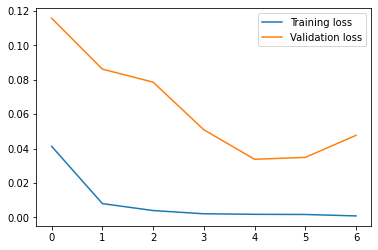

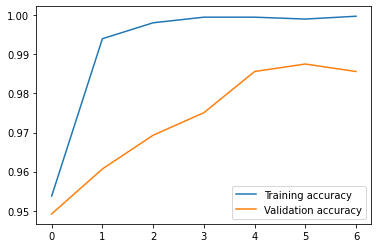

Test loss: 1.5216331481933594
Test accuracy: 0.7344835996627808


In [ ]:
mostrarEvolucion(hist)
# APLICAMOS EL TEST
score = model.evaluate(test_set, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Se puede ver que reentrenar la red entera empeora enormemente el rendimiento (pasa de 0.95 a 0.73 aproximadamente!) . Esto puede parecer ilógico, ya que antes solamente entrenamos la capa final que realiza la clasificación, y ahora estamos entrenando ligeramente todas las capas. Sin embargo, tiene sentido, ya que resnet tiene unos pesos muy buenos debido a estar entrenado con imagenet, que tiene millones de imágenes, mientras que nuestro dataset tiene solamente 6000. Además, esta pensada para clasificar 1000 clases de imagenes, mientras que nuestro problema es una sencilla clasificación binaria, por lo que un modelo más sencillo puede sufrir menos overfitting.

Podemos ver como en este caso existe un overfitting enorme: Si bien la clasificación en validación llega practicamente al 99%, en test se queda solamente en el 73%.


##ResNet50 - Modelo FC Propuesto

https://sci-hub.yncjkj.com/10.1109/IEMTRONICS51293.2020.9216455 en el punto 2.4 sale un modelo propuesto para la salida de la resnet50 y en un dataset similar alcanzan el 99% de precision 

En este apartado se utilizará el siguiente modelo:

$$\begin{array}{ccccc}
\textbf{Layer No.} & \textbf{Layer Type} & \textbf{Kernel Size} & \textbf{Dimension} & \textbf{Channels} \\
1-50      & ResNet50   & -           & 224\vert2048  & -        \\
51        & Linear     & -           & 2048\vert1024 & -        \\
52        & ReLu       & -           & 1024\vert1024 & -        \\
53        & Dropout    & -           & 1024\vert1024 & -        \\
54        & Linear     & -           & 1024\vert1    & -        \\
55        & Sigmoid    & -           & 1\vert1       & -       
\end{array}$$

La estructura está basada en el siguiente paper: https://sci-hub.yncjkj.com/10.1109/IEMTRONICS51293.2020.9216455. En el punto 2.4 se puede ver como, en un problema similar (clasificación de histologías de cáncer de mama), se logra mejorar la precisión inicial dee la red.

In [ ]:
#Obtenemos una nueva instancia de resnet50 (para recuperar los pesos originales de imagenet)
resnet = tf.keras.applications.ResNet50(include_top=False,
                                      weights='imagenet',
                                      pooling='avg',
                                      input_shape = (224,224,3),
                                      classes=1)
resnet.trainable=False

model = Sequential()
model.add(resnet)
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 25,686,913
Trainable params: 2,099,201
Non-trainable params: 23,587,712
_________________________________________________________________


Volvemos a utilizar un batch de 128 imágenes.

In [ ]:
train_set_P = image_dataset_from_directory("/content/gdrive/MyDrive/chest_xray/train",image_size=(224,224),batch_size=128,seed=123,label_mode='int',shuffle=True,validation_split=0.2,subset='training')
validation_set_P = image_dataset_from_directory("/content/gdrive/MyDrive/chest_xray/train",image_size=(224,224),batch_size=128,seed=123,label_mode='int',shuffle=True,validation_split=0.2,subset='validation')
train_set_P = train_set_P.map(preprocess_resnet)
validation_set_P = validation_set_P.map(preprocess_resnet)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy'])

Epoch 1/20
33/33 [==============================] - 51s 1s/step - loss: 0.2103 - accuracy: 0.8620 - val_loss: 0.1870 - val_accuracy: 0.9386
Epoch 2/20
33/33 [==============================] - 46s 1s/step - loss: 0.0572 - accuracy: 0.9432 - val_loss: 0.0635 - val_accuracy: 0.9770
Epoch 3/20
33/33 [==============================] - 44s 1s/step - loss: 0.0396 - accuracy: 0.9583 - val_loss: 0.0557 - val_accuracy: 0.9837
Epoch 4/20
33/33 [==============================] - 44s 1s/step - loss: 0.0300 - accuracy: 0.9674 - val_loss: 0.0869 - val_accuracy: 0.9636
Epoch 5/20
33/33 [==============================] - 46s 1s/step - loss: 0.0260 - accuracy: 0.9722 - val_loss: 0.0456 - val_accuracy: 0.9856
Epoch 6/20
33/33 [==============================] - 46s 1s/step - loss: 0.0234 - accuracy: 0.9732 - val_loss: 0.0692 - val_accuracy: 0.9703
Epoch 7/20
33/33 [==============================] - 44s 1s/step - loss: 0.0206 - accuracy: 0.9768 - val_loss: 0.0701 - val_accuracy: 0.9703
Epoch 8/20
33/33 [==

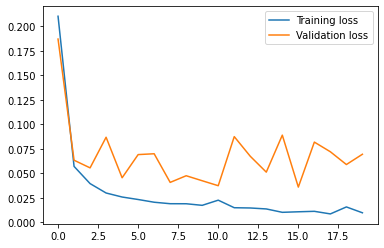

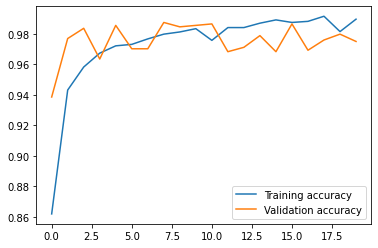

In [ ]:
hist = model.fit(x=train_set_P,
                 validation_data=validation_set_P,
                 class_weight=class_weight,
                 epochs=20)
mostrarEvolucion(hist)

In [ ]:
# APLICAMOS EL TEST
score = model.evaluate(test_set, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.09918972104787827
Test accuracy: 0.9712437391281128


Las modificaciones realizadas consiguen mejorar el modelo inicial de ResNet50, logrando una precisión muy satisfactoria.

##Cambios en la estructura del modelo

En este apartado vamos a realizar diversas modificaciones en la estructura de ResNet50 para intentar que se especialice en nuestros datos, ya que solamente realizando Fine Tunning no se obtuvo un resultado satisfactorio.

Por un lado, vamos a quedarnos solo con los 3 primeros bloques convolucionales de los 5 que componen ResNet50. De estos 3, se reentranará solo el último (manteniendo los pesos de imagenet en los dos primeros). Finalmente, añadiremos la capa linear final que realiza la clasificación. 


In [ ]:
#Limpiamos recursos de Colab
gc.collect()
keras.backend.clear_session()

#Obtenemos una nueva instancia de resnet50 (para recuperar los pesos originales de imagenet)
resnet = tf.keras.applications.ResNet50(include_top=False,
                                      weights='imagenet',
                                      pooling='avg',
                                      input_shape = (224,224,3),
                                      classes=1)


#Congelamos la primera y la segunda capa. No congelamos las de BatchNormalization porque puede dar un error keras
for layer in [l for l in resnet.layers if 'conv3' not in l.name]:
      if (not isinstance(layer, keras.layers.BatchNormalization)):
        layer.trainable = False

#Tomamos como punto de partida el final de la última capa del 3º bloque (eliminando el 4º y 5º bloque convolucional)
x = resnet.get_layer('conv3_block4_out').output
#Anhadimos Pooling ya que eliminamos el que proporciona resnet al eliminar la ultima capa
x = GlobalAveragePooling2D()(x)
#Añadimos la capa Linear
last = Dense(1,activation='sigmoid',name="lastDense")(x)
model_mod = Model(inputs=resnet.input,outputs = last)
model_mod.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

Epoch 1/10
33/33 [==============================] - 54s 1s/step - loss: 0.3142 - accuracy: 0.2655 - val_loss: 1.1473 - val_accuracy: 0.2234
Epoch 2/10
33/33 [==============================] - 47s 1s/step - loss: 0.2472 - accuracy: 0.3290 - val_loss: 0.9470 - val_accuracy: 0.2234
Epoch 3/10
33/33 [==============================] - 47s 1s/step - loss: 0.1959 - accuracy: 0.5905 - val_loss: 0.7252 - val_accuracy: 0.4410
Epoch 4/10
33/33 [==============================] - 47s 1s/step - loss: 0.1580 - accuracy: 0.7731 - val_loss: 0.5404 - val_accuracy: 0.7603
Epoch 5/10
33/33 [==============================] - 47s 1s/step - loss: 0.1308 - accuracy: 0.8373 - val_loss: 0.4111 - val_accuracy: 0.8763
Epoch 6/10
33/33 [==============================] - 47s 1s/step - loss: 0.1111 - accuracy: 0.8641 - val_loss: 0.3300 - val_accuracy: 0.9118
Epoch 7/10
33/33 [==============================] - 47s 1s/step - loss: 0.0967 - accuracy: 0.8835 - val_loss: 0.2686 - val_accuracy: 0.9319
Epoch 8/10
33/33 [==

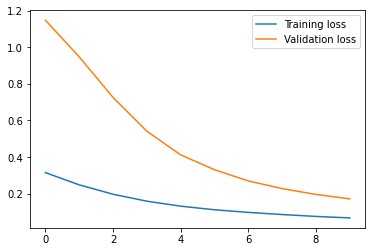

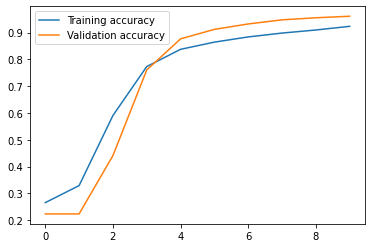

Test loss: 0.3194197118282318
Test accuracy: 0.920680582523346


In [ ]:
#############################################################
model_mod.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy'])

hist_mod = model_mod.fit(x=train_set_P,
          validation_data=validation_set_P,
          class_weight=class_weight,
          epochs=10)

###########################################################

mostrarEvolucion(hist_mod)
# APLICAMOS EL TEST
score = model_mod.evaluate(test_set, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Podemos ver como las modificaciones realizadas, si bien parecían buena idea, no han logrado mejorar la precisión lograda solamente entrenando el clasificador tras ResNet50.

#Otros Modelos

##ResNet18


In [ ]:
#Datos de entrenamiento utilizando una porción del conjunto de training como conjunto de validación
train_set = image_dataset_from_directory("/content/gdrive/MyDrive/chest_xray/train",image_size=(224,224),batch_size=128,seed=123,label_mode='int',shuffle=True,validation_split=0.2,subset='training')
validation_set = image_dataset_from_directory("/content/gdrive/MyDrive/chest_xray/train",image_size=(224,224),batch_size=128,seed=123,label_mode='int',shuffle=True,validation_split=0.2,subset='validation')
test_set = image_dataset_from_directory("/content/gdrive/MyDrive/chest_xray/test",image_size=(224,224),label_mode='int',shuffle=True)

train_set = train_set.map(preprocess_resnet)
validation_set = validation_set.map(preprocess_resnet)
test_set = test_set.map(preprocess_resnet)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Found 624 files belonging to 2 classes.


In [ ]:
resnet18 = ResNet18(1)
resnet18.build(input_shape = (None,224,224,3))
resnet18.summary()

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "res_net18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  9472      
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 resnet_block (ResnetBlock)  multiple          

Para intentar evitar el fuerte sobre-ajuste que se produce en ResNet18, definimos un callback para que el entrenamiento pare cuando se alcancen niveles de precisión y perdida en validación deseados (Precisión +96% Perdida -0.1)

Epoch 1/20
33/33 [==============================] - 142s 4s/step - loss: 0.5582 - accuracy: 0.8732 - val_loss: 260.9417 - val_accuracy: 0.2234
Epoch 2/20
33/33 [==============================] - 43s 1s/step - loss: 0.1163 - accuracy: 0.9576 - val_loss: 19.3809 - val_accuracy: 0.2330
Epoch 3/20
33/33 [==============================] - 43s 1s/step - loss: 0.0757 - accuracy: 0.9710 - val_loss: 0.4021 - val_accuracy: 0.9022
Epoch 4/20
33/33 [==============================] - 43s 1s/step - loss: 0.0822 - accuracy: 0.9698 - val_loss: 1.2273 - val_accuracy: 0.7584
Epoch 5/20
33/33 [==============================] - 46s 1s/step - loss: 0.0374 - accuracy: 0.9871 - val_loss: 0.2338 - val_accuracy: 0.9137
Epoch 6/20
33/33 [==============================] - 43s 1s/step - loss: 0.0276 - accuracy: 0.9914 - val_loss: 0.1642 - val_accuracy: 0.9482
Epoch 7/20
33/33 [==============================] - 43s 1s/step - loss: 0.0169 - accuracy: 0.9945 - val_loss: 0.0919 - val_accuracy: 0.9703


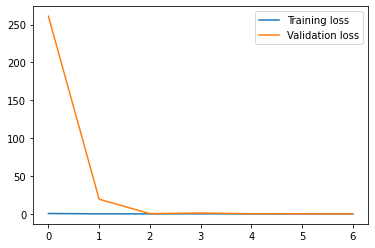

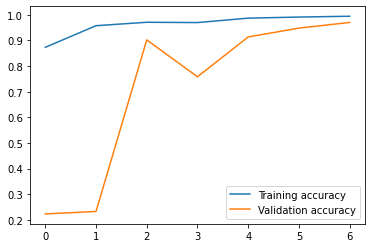

In [ ]:
resnet18.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=["accuracy"])

hist = resnet18.fit(x=train_set,
              validation_data=validation_set,
              epochs=20,
              callbacks=[trainingStopCallback])

mostrarEvolucion(hist)

In [ ]:
# APLICAMOS EL TEST
score = resnet18.evaluate(test_set, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.8455882668495178
Test accuracy: 0.7836538553237915


La precisión alcanzada en este caso es mucho inferior a la alcanzada por ResNet50. Por esto motivo, no seguiremos trabajando con este modelo.

##VGG16

En este apartado vamos a probar a utilizar de base VGG16, realizando dos variantes: entrenar solamente el clasificador y realizar las modificaciones propuestas en el paper utilizando anteriormente con ResNet50.

###VGG Base

In [ ]:
#Cargamos los datos y aplicamos la funcion de preprocesamiento especifica del modelo
train_set = image_dataset_from_directory("/content/gdrive/MyDrive/chest_xray/train",image_size=(224,224),batch_size=128,seed=123,label_mode='int',shuffle=True,validation_split=0.2,subset='training')
validation_set = image_dataset_from_directory("/content/gdrive/MyDrive/chest_xray/train",image_size=(224,224),batch_size=128,seed=123,label_mode='int',shuffle=True,validation_split=0.2,subset='validation')
test_set = image_dataset_from_directory("/content/gdrive/MyDrive/chest_xray/test",image_size=(224,224),label_mode='int',shuffle=True)

train_set = train_set.map(preprocess_vgg)
validation_set = validation_set.map(preprocess_vgg)
test_set = test_set.map(preprocess_vgg)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Found 624 files belonging to 2 classes.


In [ ]:
#Cargamos el modelo de VGG16, indicando que no vamos a reentrenar los pesos
vgg = tf.keras.applications.VGG16(include_top=False,
                                  weights='imagenet',
                                  pooling='avg',
                                  input_shape = (224,224,3))
vgg.trainable=False

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
model_vgg = Sequential()
model_vgg.add(vgg)
model_vgg.add(Dense(1,activation='sigmoid'))
model_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model_vgg.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=["accuracy"])

Epoch 1/20
33/33 [==============================] - 79s 2s/step - loss: 0.3150 - accuracy: 0.6192 - val_loss: 0.5084 - val_accuracy: 0.7613
Epoch 2/20
33/33 [==============================] - 47s 1s/step - loss: 0.1394 - accuracy: 0.8373 - val_loss: 0.2910 - val_accuracy: 0.8907
Epoch 3/20
33/33 [==============================] - 46s 1s/step - loss: 0.1028 - accuracy: 0.8926 - val_loss: 0.2466 - val_accuracy: 0.9108
Epoch 4/20
33/33 [==============================] - 47s 1s/step - loss: 0.0844 - accuracy: 0.9135 - val_loss: 0.2023 - val_accuracy: 0.9310
Epoch 5/20
33/33 [==============================] - 47s 1s/step - loss: 0.0736 - accuracy: 0.9293 - val_loss: 0.1688 - val_accuracy: 0.9444
Epoch 6/20
33/33 [==============================] - 47s 1s/step - loss: 0.0660 - accuracy: 0.9391 - val_loss: 0.1814 - val_accuracy: 0.9406
Epoch 7/20
33/33 [==============================] - 47s 1s/step - loss: 0.0620 - accuracy: 0.9410 - val_loss: 0.1496 - val_accuracy: 0.9492
Epoch 8/20
33/33 [==

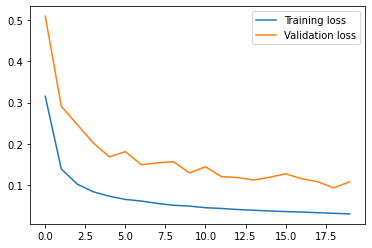

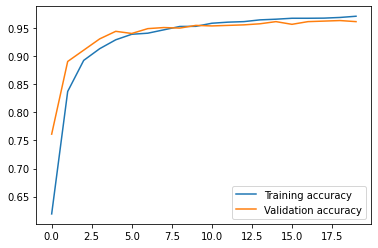

Test loss: 0.4436459243297577
Test accuracy: 0.8477563858032227


In [ ]:
hist = model_vgg.fit(x=train_set,
              validation_data=validation_set,
              class_weight=class_weight,
              epochs=20)

mostrarEvolucion(hist)

# APLICAMOS EL TEST
score = model_vgg.evaluate(test_set, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Podemos ver como el rendimiento es muy inferior al logrado por ResNet50, disminuyendo la precisión sobre el conjunto de test en casi un 10%. Esto tiene sentido, pues ResNet busca mejorar justamente los resultados obtenidos por VGG16, que es un modelo anterior.

### VGG Paper

In [ ]:
#Cargamos el modelo de VGG16, indicando que no vamos a reentrenar los pesos
vgg_paper = tf.keras.applications.VGG16(include_top=False,
                                  weights='imagenet',
                                  pooling='avg',
                                  input_shape = (224,224,3))
vgg_paper.trainable=False

#Definimos el modelo a ejecutar, basado en el paper mencionado anteriormente
model_vgg_paper = Sequential()
model_vgg_paper.add(vgg_paper)
model_vgg_paper.add(Dense(1024,activation='relu'))
model_vgg_paper.add(Dropout(0.5))
model_vgg_paper.add(Dense(1,activation='sigmoid'))
model_vgg_paper.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 15,241,025
Trainable params: 526,337
Non-trainable params: 14,714,688
_________________________________________________________________


Epoch 1/20
37/37 [==============================] - 576s 10s/step - loss: 0.2903 - accuracy: 0.8539 - val_loss: 0.3006 - val_accuracy: 0.9347
Epoch 2/20
37/37 [==============================] - 60s 1s/step - loss: 0.0689 - accuracy: 0.9448 - val_loss: 0.1842 - val_accuracy: 0.9443
Epoch 3/20
37/37 [==============================] - 60s 1s/step - loss: 0.0514 - accuracy: 0.9542 - val_loss: 0.1373 - val_accuracy: 0.9616
Epoch 4/20
37/37 [==============================] - 59s 1s/step - loss: 0.0359 - accuracy: 0.9627 - val_loss: 0.0782 - val_accuracy: 0.9731
Epoch 5/20
37/37 [==============================] - 59s 1s/step - loss: 0.0264 - accuracy: 0.9723 - val_loss: 0.0709 - val_accuracy: 0.9750
Epoch 6/20
37/37 [==============================] - 60s 1s/step - loss: 0.0255 - accuracy: 0.9772 - val_loss: 0.0620 - val_accuracy: 0.9750
Epoch 7/20
37/37 [==============================] - 59s 1s/step - loss: 0.0225 - accuracy: 0.9766 - val_loss: 0.0590 - val_accuracy: 0.9770
Epoch 8/20
37/37 [

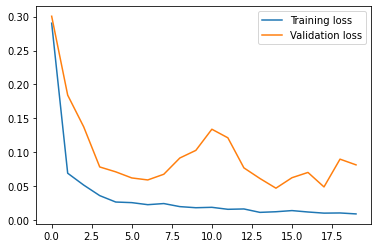

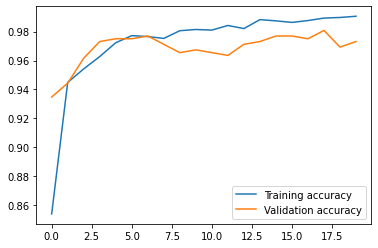

Test loss: 0.710446834564209
Test accuracy: 0.8365384340286255


In [ ]:
model_vgg_paper.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=["accuracy"])


hist_vgg_paper = model_vgg_paper.fit(x=train_set,
              validation_data=validation_set,
              class_weight=class_weight,
              epochs=20)

mostrarEvolucion(hist_vgg_paper)

# APLICAMOS EL TEST
score = model_vgg_paper.evaluate(test_set, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Si bien con ResNet las modificaciones anteriores dieron resultado, en este caso no dieron resultado, siendo la precisión es similar o incluso un poco inferior. 

##MobileNetV2

Vamos a probar a utilizar ahora de base MobileNetV2. Este modelo fue desarrollado pensando en su ejecución en dispositivos móviles, buscando tiempos de entrenamientos menores.

En este caso, vamos a añadir solamente una capa final que relice la función de clasificador, de manera similar a como se hizo en la primera versión de ResNet50 del proyecto.

In [ ]:
#Cargamos los datos y aplicamos la funcion de preprocesamiento especifica del modelo
train_set = image_dataset_from_directory("/content/gdrive/MyDrive/chest_xray/train",image_size=(224,224),batch_size=128,seed=123,label_mode='int',shuffle=True,validation_split=0.2,subset='training')
validation_set = image_dataset_from_directory("/content/gdrive/MyDrive/chest_xray/train",image_size=(224,224),batch_size=128,seed=123,label_mode='int',shuffle=True,validation_split=0.2,subset='validation')
test_set = image_dataset_from_directory("/content/gdrive/MyDrive/chest_xray/test",image_size=(224,224),label_mode='int',shuffle=True)

train_set = train_set.map(preprocess_mobile)
validation_set = validation_set.map(preprocess_mobile)
test_set = test_set.map(preprocess_mobile)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Found 624 files belonging to 2 classes.


In [ ]:
#Cargamos el mododelo de MobileNetV2, indicando que no vamos a reentrenar los pesos
mobileNet = tf.keras.applications.MobileNetV2(include_top=False,
                                  weights='imagenet',
                                  pooling='avg',
                                  input_shape = (224,224,3))
mobileNet.trainable=False

In [ ]:
model_mobile = Sequential()
model_mobile.add(mobileNet)
model_mobile.add(Dense(1,activation='sigmoid'))
model_mobile.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model_mobile.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=["accuracy"])

Epoch 1/30
33/33 [==============================] - 38s 744ms/step - loss: 0.1882 - accuracy: 0.8009 - val_loss: 0.3481 - val_accuracy: 0.8763
Epoch 2/30
33/33 [==============================] - 30s 761ms/step - loss: 0.0956 - accuracy: 0.9267 - val_loss: 0.2207 - val_accuracy: 0.9214
Epoch 3/30
33/33 [==============================] - 31s 771ms/step - loss: 0.0729 - accuracy: 0.9401 - val_loss: 0.1691 - val_accuracy: 0.9386
Epoch 4/30
33/33 [==============================] - 34s 889ms/step - loss: 0.0622 - accuracy: 0.9439 - val_loss: 0.1505 - val_accuracy: 0.9453
Epoch 5/30
33/33 [==============================] - 31s 764ms/step - loss: 0.0560 - accuracy: 0.9487 - val_loss: 0.1307 - val_accuracy: 0.9549
Epoch 6/30
33/33 [==============================] - 35s 895ms/step - loss: 0.0509 - accuracy: 0.9538 - val_loss: 0.1417 - val_accuracy: 0.9453
Epoch 7/30
33/33 [==============================] - 31s 770ms/step - loss: 0.0479 - accuracy: 0.9552 - val_loss: 0.1169 - val_accuracy: 0.9607

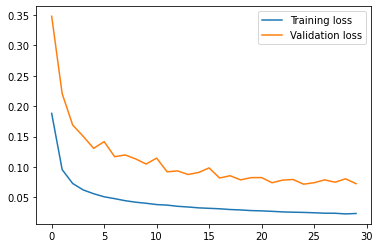

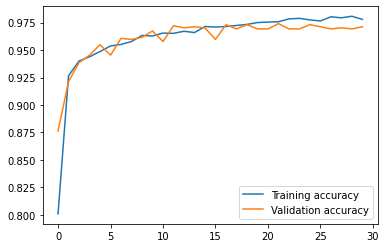

In [ ]:
hist_mobile = model_mobile.fit(x=train_set,
              validation_data=validation_set,
              class_weight=class_weight,
              epochs=30)

mostrarEvolucion(hist_mobile)

In [ ]:
# APLICAMOS EL TEST
score = model_mobile.evaluate(test_set, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.3951548635959625
Test accuracy: 0.8509615659713745


Se puede ver como la precisión, si bien es menor que ResNet50, es superior a VGG16. En este caso es preferible el uso de este modelo que VGG16, ya que los tiempos de entrenamiento son mucho menores.